## Goal: estimate satisfaction function of a formula from instances of its satisfaction on individual runs at discrete parameter values

We use Gaussian Process Classification to estimate the satisfaction function.
Problem: the exact computation of the posterior probability is not possible --> use approximation from **Expectation Propagation (EP)** approach (high accuracy + computational efficiency) 

EP computes a Gaussian approximation to probabilistic models of the form
$ p(x|y) = p_0(x) \prod_i t_i (y_i,x_i)$   

$p_0(x)$ is a multivariate Gaussian distribution coupling all $x_i$ variables (*site variables*), $t_i$ can be general univariate distributions. Those models are calles *latent Gaussian models*: p0 represents prior distribution, with ti representing non-Gaussian observation likelihoods.  
EP approximation: likelihood terms replaced by univariate Gaussian terms $ q(x|y) = p_0(x) \prod_i \tilde{t}_i (y_i,x_i) $  



In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math

from scipy.optimize import minimize
from scipy.stats import bernoulli
from scipy.special import expit as sigmoid

from sklearn.datasets import make_moons
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

%matplotlib inline



# Kernel

We place a GP prior over the latent function $f(x)$ and then squash it to obtain the prior on $\pi(x) = p(y=1|x) = \sigma(f(x))$.  
We use the squared exponential covariance function $k(x,x')= \sigma^2 exp(- \frac{(x-x')^2}{2\lambda^2}) $.  
Squash it with: the logistic logit ($\lambda(z) = \frac{1}{1+ exp(-z)}$) and the probit transformation (cdf of normal distribution, $\Phi(z) = \int^z_{-\inf} \mathcal{N}(x|0,1)dx$).

We don't observe values of f itself, only onputs X and class labels y. We are only interested in $\pi$.

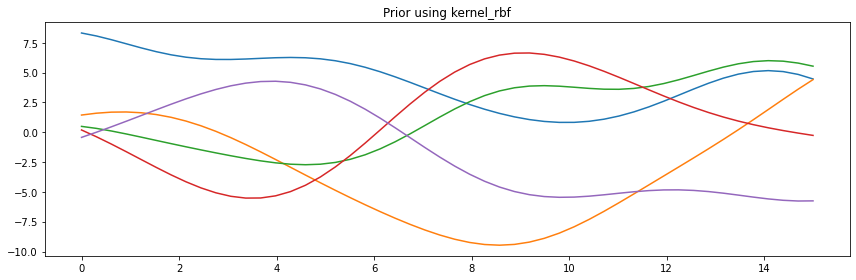

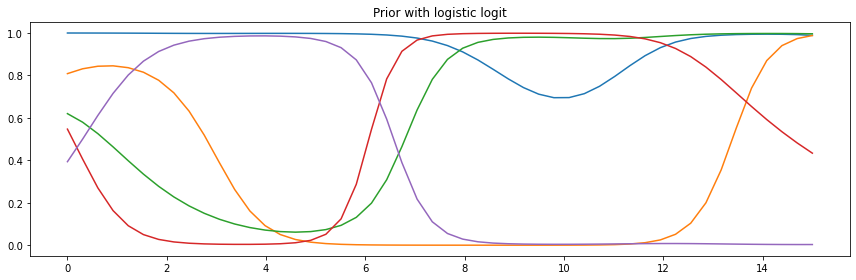

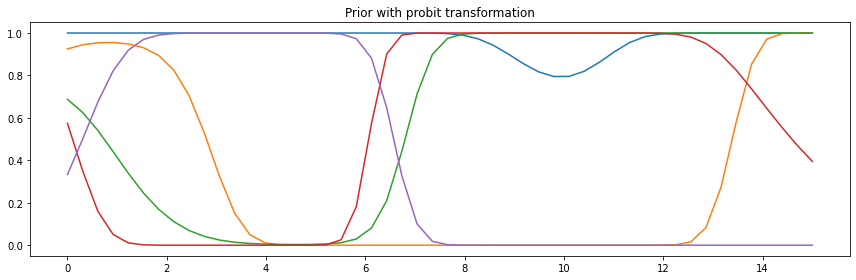

In [2]:
from scipy.stats import norm

def kernel_rbf(X1, X2, param):
    """
    Isotropic squared exponential kernel.

    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).
        param: Kernel parameters

    Returns:
        (m x n) matrix
    """

    sqdist = np.sum(X1 ** 2, 1).reshape(-1, 1) + np.sum(X2 ** 2, 1) - 2 * np.dot(X1, X2.T)
    return param[1] ** 2 * np.exp(-0.5 / param[0] ** 2 * sqdist)



# define all hyperparameters for all kernels
params = [3, 5]


# Test Data: N points from 0 to 15
N_s = 50
X_s = np.linspace(0, 15, N_s).reshape(-1,1)


# Prior using RBF 
plt.figure(figsize=(12, 4))

# compute mean and covariance
mu_prior = np.zeros(X_s.shape)
cov_prior = kernel_rbf(X_s, X_s, params)
# sample 5 normals from GP prior and plot
f_prior = np.random.multivariate_normal(mu_prior.ravel(), cov_prior, 5)
for sample in f_prior:
    plt.plot(X_s, sample, lw=1.5, ls='-')
plt.title(f'Prior using {kernel_rbf.__name__}')
plt.tight_layout()        
plt.show()



def log_logit(xs):
    return 1/(1+np.exp(-xs))

    
# Prior using RBF 
plt.figure(figsize=(12, 4))

# sample 5 normals from GP prior and plot
for sample in f_prior:
    plt.plot(X_s, log_logit(sample), lw=1.5, ls='-')
plt.title(f'Prior with logistic logit')
plt.tight_layout()        
plt.show()


plt.figure(figsize=(12, 4))
# sample 5 normals from GP prior and plot
for sample in f_prior:
    plt.plot(X_s, norm.cdf(sample), lw=1.5, ls='-')
plt.title(f'Prior with probit transformation')
plt.tight_layout()        
plt.show()

## Inference

2 steps:  
- compute distribution of latent variable corresponding to a test case: $p(f_*|X,y,x_*) = \int p(f_*|X,x_*,f) p(f|X,y) df$, where $p(f|X,y) = p(y|f)p(f|X)/p(y|X)$ is the posterior over the latent variables      

   
     
- use this distribution over latent $f_*$ to produce probabilistic prediction: $\overline{x}_* = p(y_*=1|X,y,x_*) = \int \sigma(f_*)p(f_*|X,y,x_*)df$   


Non-Gaussian likelihood makes integral intractable $\rightarrow$ approximate with Gaussian posterior $\Rightarrow$ Expectation Propagation algorithm

## Expectation Propagation

Posterior given by Bayes rule as product of normalization term, prior and likelihood: $p(f|X,y) = \frac{1}{Z} p(f|X) \prod p(y_i|f_i)$  
Prior $p(f|X)$ is Gaussian  
Likelihood factorizes over training cases  
Normalization term = marginal likelihood: $Z = p(y|X) = \int p(f|X) \prod p(y_i|f_i) df$  

Probit likelihood for binary classification: $p(y_i|f_i) = \Phi(f_iy_i)$  
$\rightarrow$ approximate by local likelihood approximation (unnormalized Gaussian function in latent variable $f_i$): $p(y_i|f_i) \approx t_i ( f_i|\tilde{Z}_i,\tilde{\mu}_i,\tilde{\sigma}_i^2) = \tilde{Z}_i \mathcal{N}(f_i|\tilde{\mu}_i,\tilde{\sigma}_i^2)$  

Product of independent local likelihoods $t_i$: $\prod t_i(f_i| \tilde{Z}_i,\tilde{\mu}_i,\tilde{\sigma}_i^2) = \mathcal{N}(\tilde{\mu},\tilde{\Sigma}) \prod \tilde{Z}_i$, where $\tilde{\mu}$ is vector of $\tilde{\mu}_i$ and $\tilde{\Sigma}$ is diagonal with $\tilde{\Sigma}_{ii} = \tilde{\sigma}^2_i$.  

Approximate posterior $p(f|X,y)$ by: $q(f|X,y) = \frac{1}{Z_{EP}} p(f|X) \prod t_i(f_i| \tilde{Z}_i,\tilde{\mu}_i,\tilde{\sigma}_i^2) = \mathcal{N}(\mu,\Sigma)$ [3.53] with $Z_{EP}=q(y|X)$ (approximation to normalizing term Z from previous eq.), $\mu=\Sigma\tilde{\Sigma}^{-1}\tilde{\mu}$ and $\Sigma=(K^{-1}+\tilde{\Sigma}^{-1})^{-1}$  

### How do we choose parameters of local approximating distributions $t_i$?  
Update individual $t_i$ approximations sequentially. Iterate these 4 steps until convergence:  
1. start from some current approximate posterior, from which we leave out current $t_i$ $\rightarrow$ marginal cavity distribution  
2. Combine cavity distribution with exact likelihood $p(y_i|f_i)$ to get desired (non-Gaussian) marginal  
3. Choose Gaussian approximation to marginal  
4. Compute the $t_i$ which makes posterior have the desired marginal from step 3   

Approximate posterior for $f_i$ contains 3 kinds of terms:  
1. Prior $p(f|X)$  
2. Local approximate likelihoods $t_j$ for all cases $j\neq i$  
3. Exact likelihood for case i, $p(y_i|f_i) = \Phi(y_if_i)$   

Goal: combine these sources of information and choose parameters of $t_i$ such that the marginal posterior is as accurate as possible. 

1. Combine prior and local likelihood approximations into cavity distribution: $q_{-i}(f_i) \propto \int p(f|X) \prod_{j\neq i} t_j (f_j|\tilde{Z}_j, \tilde{\mu}_j, \tilde{\sigma}_j^2) df_j$  
Either by explicitly multiplying out the terms, or by removing approximate likelihood i from the approximate posterior in 3.53.
2. Combine this with exact likelihood for case i. 

### 1) Set initial parameters and perform statistical model checking (SMC 157)
Here no estimates, just 0/1 (therefore just invent outputs)

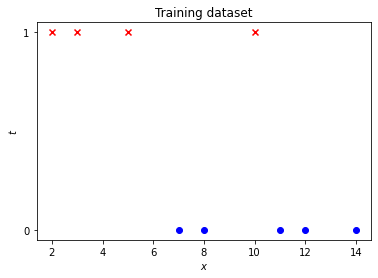

In [8]:
import numpy.matlib

# parameters from smoothed model checking
#N = 9
#numberOfTestPoints = 9
simulation_runs = 1
paramValueSet = np.array([2,3,5,7,8,10,11,12,14]).reshape(-1,1) # uncertain parameter that is varied = population size
datapoints = 9
paramValueOutputs = np.array([1,1,1,0,0,1,0,0,0]) # outputs of satisfaction (eig. #true/runs, aber hier nur 1 run)
data = trainingSet = [paramValueSet, paramValueOutputs] # set as training set for GP

#print(data)

X_test = np.arange(0, 18, 0.5).reshape(-1, 1)

# plot data
plt.scatter(paramValueSet[paramValueOutputs == 0], paramValueOutputs[paramValueOutputs == 0], marker='o', c='blue')
plt.scatter(paramValueSet[paramValueOutputs == 1], paramValueOutputs[paramValueOutputs == 1], marker='x', c='red')
plt.title('Training dataset')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.yticks([0, 1])
plt.show()



### 2) Perform smoothed model checking (SMC 65)

getAnalyticApproximation(data, parameters, options) (100)  
-> optimize hyperparameters  
-> doTraining (142)  
   -> expectationPropagation

In [26]:
# optimize hyperparameters of kernel, here not, just take default values
params = [0.7, 1]


# do training: gauss = expectationPropagation(1e-6) 119
# first: all zero
gauss_C = kernel_rbf(paramValueSet, paramValueSet, params) #+ 1e-4  # covariance training
gauss_LC_t = np.linalg.cholesky(gauss_C + 1e-4 * np.eye(datapoints))  # cholesky decomposition, returns A=U'*U
gauss_LC = gauss_LC_t.T  # transpose L' (or other way round?)
gauss_LC_diag = np.diagonal(gauss_LC)

logdet_LC = 2*np.sum(np.log(gauss_LC_diag))
logZprior = 0.5*logdet_LC

logZterms = np.zeros(datapoints)
logZloo = np.zeros(datapoints)
Term = np.zeros((datapoints, 2))  # Term[:,0] = v tilde, Term[:,1] = tau tilde


computeMarginalMoments(gauss, Term) 335

In [27]:
## compute marginal moments (initialization)

# tmp = Term[1]*gauss_LC -> all 0
tmp = np.multiply(numpy.matlib.repmat(Term[:,1], datapoints, 1), gauss_LC)
# A = LC' * tmp + I (correction)
A = np.matmul(gauss_LC_t, tmp) + np.multiply(np.eye(datapoints), 1)  
print(A) # 1 in diagonal, other 0

gauss_L = np.linalg.cholesky(A).T  
print(gauss_L) # still 1 in diagonal, other 0 

# W = L\LC'
gauss_W = np.linalg.solve(gauss_L, gauss_LC_t)
print(gauss_W)

# diagV = sum(W*W, 1)
gauss_diagV = (np.multiply(gauss_W, gauss_W)).sum(axis=0) # sum each column of W^2
print(gauss_diagV)

# m = W'*(W*Term[0])
tmp = np.matmul(gauss_W, Term[:,0])
gauss_m = np.matmul(gauss_W.T, tmp)  # 0 because Term is 0
print(gauss_m)
                
# logdet = -2*dum(log(diag(L))) + 2*sum(log(diag(LC)))
logdet = -2*np.sum(np.log(np.diag(gauss_L))) # + 2*np.sum(np.log(np.diag(gauss_LC))) (das ist schon logdet_LC)
print(logdet)
logdet += logdet_LC
print(logdet)

# logZappx = 1/2(m' * Term[0] + logdet)
logZappx = 0.5 * (np.dot(gauss_m.T, Term[:,0]) + logdet)
print(logZappx)


[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[1.00005000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [3.60429768e-01 9.32839956e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.02697430e-04 1.80554755e-02 9.99886988e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [8.33753023e-12 8.70271239e-08 

Things related to likelihood  
Gauss-Hermite: quadrature to approximate values of integral; returns abscissas (x) and weights (w) of n-point Gauss-Hermite quadrature formula

In [28]:
## stuff related to likelihood
# true observation values (not statistical mean)
gauss_LikPar_p = paramValueOutputs
gauss_LikPar_q = 1 - paramValueOutputs  # (eigentlich #trajectories - outputs)
nodes = 96
gauss_xGauss = np.zeros((nodes, 1))
gauss_wGauss = np.zeros((nodes, 1))

#gausshermite(nodes, gauss_xGauss, gauss_wGauss) -> n, x, w
#https://indico.frib.msu.edu/event/15/attachments/40/157/Gaussian_Quadrature_Numerical_Recipes.pdf
x0 = gauss_xGauss
w0 = gauss_wGauss
m = int((nodes+1)/2)
z,pp,p1,p2,p3 = 0,0,0,0,0
for i in range(m):
    if i==0:
        z = np.sqrt(2*nodes+1) - 1.85575 * ((2*nodes+1)**-0.166667)
    elif i==1:
        z = z - 1.14 * nodes**0.426 / z
    elif i==2:
        z = 1.86 * z - 0.86 * x0[0]
    elif i==3:
        z = 1.91 * z - 0.91 * x0[1]
    else:
        z = 2.0 * z - x0[i - 2]
    
    for its in range(10):
        p1 = 1/np.sqrt(np.sqrt(np.pi))
        p2 = 0
        for j in range(1,nodes+1):
            p3=p2
            p2=p1
            a = z*np.sqrt(2/j)*p2
            b = np.sqrt((j-1)/j)*p3
            p1=a-b
        pp=np.sqrt(2*nodes)*p2
        z1=z
        z=z1-p1/pp
        if np.abs(z-z1)<2.2204e-16:
            break
    
    x0[i] = z
    x0[nodes-1-i] = -z
    w0[i] = 2/(pp*pp)
    w0[nodes-1-i] = w0[i]
    
w0 = np.divide(w0, np.sqrt(np.pi))
x0 = np.multiply(x0, np.sqrt(2))
x0 = np.sort(x0, axis=None)

gauss_xGauss=x0
gauss_wGauss=w0
       
print(gauss_xGauss)  # 1 array with 96 (= nodes) entries

gauss_logwGauss = np.log(gauss_wGauss)
#print(gauss_logwGauss)

[-18.54900896 -17.71900805 -17.03392905 -16.42414008 -15.86305703
 -15.3369878  -14.83772298 -14.3598556  -13.89958774 -13.45412323
 -13.02132803 -12.59952643 -12.1873718  -11.78376099 -11.38777557
 -10.99864015 -10.61569213 -10.23835931  -9.86614278  -9.49860392
  -9.13535408  -8.77604655  -8.42036997  -8.06804314  -7.71881063
  -7.37243927  -7.02871513  -6.68744106  -6.34843453  -6.01152588
  -5.67655674  -5.34337869  -5.01185214  -4.68184527  -4.35323316
  -4.02589701  -3.69972343  -3.37460381  -3.05043374  -2.72711256
  -2.4045428   -2.08262983  -1.76128143  -1.44040739  -1.11991923
  -0.7997298   -0.47975303  -0.15990355   0.15990355   0.47975303
   0.7997298    1.11991923   1.44040739   1.76128143   2.08262983
   2.4045428    2.72711256   3.05043374   3.37460381   3.69972343
   4.02589701   4.35323316   4.68184527   5.01185214   5.34337869
   5.67655674   6.01152588   6.34843453   6.68744106   7.02871513
   7.37243927   7.71881063   8.06804314   8.42036997   8.77604655
   9.13535

### Expectation Propagation iterations until convergence (168)
-> compute cavities  
-> update  
    GaussHermiteNQ: calculate mu_hat, sigma_hat^2 (Cumul[0],Cumul[1])  
    $\Phi(f(x)) = 1/2 (1+ erf(x/\sqrt(2)))$  
-> compute marginal moments

In [29]:
from scipy.special import erf 

## cycle control -> optimize until convergence
MaxIter=100
tol=1e-6
logZold=0
logZ = 2*tol
steps=0
logZappx=0
eps_damp=0.5
    
    
    
def ep_update(cav_diagV, cav_m, Term, eps_damp, null, gauss_LikPar_p,
                      gauss_LikPar_q, gauss_xGauss, gauss_logwGauss):
    
    Cumul_i = np.zeros((datapoints, 2))
    logZ, Cumul = GaussHermiteNQ(gauss_LikPar_p, gauss_LikPar_q, cav_m, cav_diagV, gauss_xGauss, gauss_logwGauss, Cumul_i)
    
    m2 = cav_m**2
    #print(m2)
    logV = np.log(cav_diagV)
    #print(logV)
    
    cumul1 = Cumul[:,0]**2
    #print(cumul1)
    
    cumul2 = np.log(Cumul[:,1])
    
    # logZterms = logZ + 1/2 ...
    logZterms = logZ + np.multiply(np.divide(m2, cav_diagV) + logV - (np.divide(cumul1, Cumul[:,1]) + cumul2), 1/2)
    #print(logZterms)
    
    c1 = np.divide(Cumul[:,0], Cumul[:,1]) - (np.divide(cav_m, cav_diagV))
    c2 = np.divide(np.ones(9), Cumul[:,1]) - (np.divide(np.ones(9), cav_diagV))
    
    TermNew = np.array([c1, c2]).T
    TermNew = np.multiply(Term, (1 - eps_damp)) + np.multiply(TermNew, eps_damp)
    #print(TermNew)
    return TermNew, logZterms, logZ
    
    
def GaussHermiteNQ(FuncPar_p, FuncPar_q, m, v, xGH, logwGH, Cumul):#
    Nnodes = len(xGH)
    stdv = np.sqrt(v)
    print("stdv", stdv)
    print(np.shape(stdv))
    print("xGH", xGH)
    print(np.shape(xGH))
    print("xGH 2222", xGH)
    print(np.shape(xGH.reshape(-1,1)))
    print("1. mal", np.matmul(stdv.reshape(-1,1), xGH.reshape(1,-1)))
    print("2. mal", np.matmul(stdv, xGH.reshape(1,-1)))
    
    
    
    print("m", m)
    print(np.shape(m))
    
    Y = np.matmul(stdv.reshape(-1,1), xGH.reshape(1,-1)) + numpy.matlib.repmat(m.reshape(-1,1), 1, Nnodes)
    # logprobitpow returns (9, 96) ; logwGH shape (96,1)  ->  G (9, 96)
    G = np.array(logprobitpow(Y, FuncPar_p, FuncPar_q) + numpy.matlib.repmat(logwGH.T, 9, 1))
    # maximum of each row (input value) over all 96 nodes
    maxG = G.max(axis=1)
    # subtract maximum value
    G = G - np.matlib.repmat(maxG.reshape(-1,1), 1, 96)
    # exponential value
    expG = np.exp(G)
    # denominator (row sum)
    denominator = expG.sum(axis=1)
    logdenominator = np.log(denominator)
    logZ = maxG + logdenominator

    # deltam = stdv * (expG * xGH) / denominator
    #print(np.shape(expG))
    #print(np.shape(xGH))
    #print(np.shape(np.matmul(expG, xGH)))
    deltam = np.divide(np.multiply(stdv, np.matmul(expG, xGH)), denominator)
    #print(deltam)
    # mu hat = mu-1 + deltam
    Cumul[:,0] = m + deltam
    
    xGH2 = xGH**2
    deltam2 = deltam**2
    #print(np.shape(v))
    Cumul[:,1] = np.divide(np.multiply(v, np.matmul(expG, xGH2)), denominator) - deltam2
    
    #print(Cumul)
    
    return logZ, Cumul
    
def logprobitpow(X, p, q):
    # ncdflogbc for matrices, because x in X is row with 96 values
    threshold = -np.sqrt(2)*5
    Za = []
    y = []
    j = 0
    for x in X:
        y.append([])
        #print(j)
        for i in x:
            if i >= 0:
                y[j].append(np.log(1 + erf(i/np.sqrt(2))) - np.log(2))
            elif ((threshold < i) and (i < 0)):
                y[j].append(np.log(1 - erf((-i)/np.sqrt(2))) - np.log(2))
            elif i <= threshold:
                y[j].append(-1/2 * np.log(np.pi) - np.log(2) - 1/2 * (-i) * (-i) - \
                np.log((-i)) + np.log(1 - 1/(-i) + 3/((-i)**4) - 15/((-i)**6) + 105/((-i)**8) - 945/((-i)**10)))
        j+=1
    Za = np.multiply(y, numpy.matlib.repmat(p.reshape(-1,1), 1, 96))

    Zb = []
    y = []
    j = 0
    for x in (-X):
        y.append([])
        #print(j)
        for i in x:
            if i >= 0:
                y[j].append(np.log(1 + erf(i/np.sqrt(2))) - np.log(2))
            elif ((threshold < i) and (i < 0)):
                y[j].append(np.log(1 - erf((-i)/np.sqrt(2))) - np.log(2))
            elif i <= threshold:
                y[j].append(-1/2 * np.log(np.pi) - np.log(2) - 1/2 * (-i) * (-i) - \
                np.log((-i)) + np.log(1 - 1/(-i) + 3/((-i)**4) - 15/((-i)**6) + 105/((-i)**8) - 945/((-i)**10)))
        j+=1

    Zb = np.multiply(y, numpy.matlib.repmat(q.reshape(-1,1), 1, 96))
    return Za + Zb
    
    
def computeMarginalMoments(gauss_LC, gauss_LC_t, Term):

    # tmp = Term[1]*gauss_LC 
    tmp = np.multiply(numpy.matlib.repmat(Term[:,1], datapoints, 1), gauss_LC)
    # A = LC' * tmp + I (correction)
    A = np.matmul(gauss_LC_t, tmp) + np.multiply(np.eye(datapoints), 1)  
    #print(A) 

    gauss_L = np.linalg.cholesky(A).T  
    #print(gauss_L) 

    # W = L\LC'
    gauss_W = np.linalg.solve(gauss_L, gauss_LC_t)
    #print(gauss_W)

    # diagV = sum(W*W, 1)
    gauss_diagV = (np.multiply(gauss_W, gauss_W)).sum(axis=0) # sum each column of W^2
    #print(gauss_diagV)

    # m = W'*(W*Term[0])
    tmp = np.matmul(gauss_W, Term[:,0])
    gauss_m = np.matmul(gauss_W.T, tmp)  
    #print(gauss_m)

    # logdet = -2*dum(log(diag(L))) + 2*sum(log(diag(LC)))
    logdet = -2*np.sum(np.log(np.diag(gauss_L))) # + 2*np.sum(np.log(np.diag(gauss_LC))) (das ist schon logdet_LC)
    #print(logdet)
    logdet += logdet_LC
    #print(logdet)

    # logZappx = 1/2(m' * Term[0] + logdet)
    logZappx = 0.5 * (np.dot(gauss_m.T, Term[:,0]) + logdet)
    #print(logZappx)
    return logZappx

    

while (np.abs(logZ-logZold)>tol) and (steps<MaxIter):
#while (steps==0):
    steps += 1
    logZold = logZ
    
    # compute cavities cavGauss = ComputeCavities(gauss, Term.neg()) 260
    C = gauss_diagV
    # s = 1/(1+Term[1]*C)
    s = np.divide(np.ones(len(C)), (1 + np.multiply(-Term[:,1], C)))
    #print(s)
    # diagV = s*C
    cav_diagV = np.multiply(s, C)
    # m = s*(m+Term[0]*C)
    cav_m = np.multiply(s, (gauss_m + np.multiply(-Term[:,0], C)))
    
    # ep update
    Term, logZterms, logZ = ep_update(cav_diagV, cav_m, Term, eps_damp, None, gauss_LikPar_p,
                      gauss_LikPar_q, gauss_xGauss, gauss_logwGauss)
        
    logZappx = computeMarginalMoments(gauss_LC, gauss_LC_t, Term)
    
    logZ = logZterms.sum() + logZappx
    #print(logZ)
    #print(logZold)


stdv [1.06301911 0.93301467 1.0000295  1.06290188 0.93299551 1.06301906
 1.00720449 0.92511349 0.99988428]
(9,)
xGH [-18.54900896 -17.71900805 -17.03392905 -16.42414008 -15.86305703
 -15.3369878  -14.83772298 -14.3598556  -13.89958774 -13.45412323
 -13.02132803 -12.59952643 -12.1873718  -11.78376099 -11.38777557
 -10.99864015 -10.61569213 -10.23835931  -9.86614278  -9.49860392
  -9.13535408  -8.77604655  -8.42036997  -8.06804314  -7.71881063
  -7.37243927  -7.02871513  -6.68744106  -6.34843453  -6.01152588
  -5.67655674  -5.34337869  -5.01185214  -4.68184527  -4.35323316
  -4.02589701  -3.69972343  -3.37460381  -3.05043374  -2.72711256
  -2.4045428   -2.08262983  -1.76128143  -1.44040739  -1.11991923
  -0.7997298   -0.47975303  -0.15990355   0.15990355   0.47975303
   0.7997298    1.11991923   1.44040739   1.76128143   2.08262983
   2.4045428    2.72711256   3.05043374   3.37460381   3.69972343
   4.02589701   4.35323316   4.68184527   5.01185214   5.34337869
   5.67655674   6.01152588

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 9)

doTraining after EP

In [20]:
v_tilde = Term[:,0]
tau_tilde = Term[:,1]
diagSigma_tilde = 1/tau_tilde
mu_tilde = np.multiply(v_tilde, diagSigma_tilde)
Sigma_tilde = np.diag(diagSigma_tilde)

invC = np.linalg.solve((gauss_C + Sigma_tilde), np.eye(len(mu_tilde)))

print(invC)

[[ 3.67552493e-01 -4.87920078e-02  2.86691387e-04 -1.77584695e-06
   2.24897774e-07 -1.32708902e-09  1.67793529e-10 -1.40457098e-11
   8.02450952e-14]
 [-4.87920078e-02  3.74765185e-01 -2.30598697e-03  1.42844498e-05
  -1.80902215e-06  1.06747773e-08 -1.34968984e-09  1.12980231e-10
  -6.45471789e-13]
 [ 2.86691387e-04 -2.30598697e-03  3.64828881e-01 -2.26170380e-03
   2.86439034e-04 -1.69023835e-06  2.13709162e-07 -1.78892299e-08
   1.02203661e-10]
 [-1.77584695e-06  1.42844498e-05 -2.26170380e-03  3.67573802e-01
  -4.87948864e-02  2.88600216e-04 -3.64935825e-05  3.05499682e-06
  -1.74537019e-08]
 [ 2.24897774e-07 -1.80902215e-06  2.86439034e-04 -4.87948864e-02
   3.74766600e-01 -2.32128932e-03  2.94114444e-04 -2.46496104e-05
   1.40839763e-07]
 [-1.32708902e-09  1.06747773e-08 -1.69023835e-06  2.88600216e-04
  -2.32128932e-03  3.67545834e-01 -4.88288854e-02  4.20145503e-03
  -2.40536834e-05]
 [ 1.67793529e-10 -1.34968984e-09  2.13709162e-07 -3.64935825e-05
   2.94114444e-04 -4.8828885

log-likelihood = gp.getMarginalLikelihood -> nochmal EP machen und dann = logZ

73: to get post, getTestpoints, then approx.getValuesAt(testPoints) --> approx is AnalyticApproximation we just did. getValuesAt(): returns gp.getGpPosterior(testset) = GPEP 58

### get posterior  

Frage: sollte test set nicht größer sein als meine 9 gesampelten punkte? woher kommt test set? 

In [24]:
# test set: 100 points from 1 to 20
#testpoints = (np.arange(20) + 1).reshape(-1,1)
testpoints = X_s = np.linspace(0, 20, 100).reshape(-1,1)
#print(testpoints)

# calculate variances of testset and covariances of test & training set (apply kernel)
kss = kernel_rbf(testpoints, testpoints, params) #+ 1e-4  
print(kss)
ks = kernel_rbf(testpoints, paramValueSet, params)
#ks = kernel_rbf(paramValueSet, testpoints, params)

# mean
fs = np.matmul(np.matmul(ks, invC), mu_tilde)
#fs = ks.T.dot(np.linalg.solve(invC.T, np.linalg.solve(invC, mu_tilde)))
print(fs)

# var
vfs = np.diagonal(kss) - (np.diagonal(np.matmul(np.matmul(ks, invC), ks.T)))
#v = np.linalg.solve(invC, ks)
#vfs = kss - v.T.dot(v)
print(vfs)


[[1.00000000e+000 9.59210179e-001 8.46554876e-001 ... 6.71034527e-171
  1.99494871e-174 5.45690209e-178]
 [9.59210179e-001 1.00000000e+000 9.59210179e-001 ... 2.07675639e-167
  6.71034527e-171 1.99494871e-174]
 [8.46554876e-001 9.59210179e-001 1.00000000e+000 ... 5.91362528e-164
  2.07675639e-167 6.71034527e-171]
 ...
 [6.71034527e-171 2.07675639e-167 5.91362528e-164 ... 1.00000000e+000
  9.59210179e-001 8.46554876e-001]
 [1.99494871e-174 6.71034527e-171 2.07675639e-167 ... 9.59210179e-001
  1.00000000e+000 9.59210179e-001]
 [5.45690209e-178 1.99494871e-174 6.71034527e-171 ... 8.46554876e-001
  9.59210179e-001 1.00000000e+000]]
[ 8.87364679e-03  1.94705612e-02  3.93655281e-02  7.33887877e-02
  1.26294369e-01  2.00935642e-01  2.96224863e-01  4.05917948e-01
  5.19206990e-01  6.23256597e-01  7.06598165e-01  7.61640381e-01
  7.85162286e-01  7.77191250e-01  7.39863376e-01  6.77622040e-01
  5.98593682e-01  5.15518220e-01  4.44476033e-01  4.00952283e-01
  3.94517659e-01  4.24448529e-01  4.784

new ProbitRegressionPosterior(data, mean, var) 11

In [36]:

def standardNormalCDF(x):
    return 1/2 + 1/2 * erf(x * (1/np.sqrt(2)))

cached_denominator = 1 / np.sqrt(1 + vfs)

print(cached_denominator)

probabilities = standardNormalCDF(fs * cached_denominator)
print(probabilities)


# how to compute uncertainty of prediction with variance?
#uncertainty = 1.96 * np.sqrt(vfs)

lowerbound = standardNormalCDF(fs - 1.96 * np.sqrt(vfs) *
                              cached_denominator)
upperbound = standardNormalCDF(fs + 1.96 * np.sqrt(vfs) *
                              cached_denominator)

print(lowerbound)
print(upperbound)

[0.70712527 0.70719521 0.70746491 0.70833557 0.71068486 0.71597489
 0.72587985 0.74112016 0.75978813 0.7767488  0.7865131  0.78843023
 0.78742142 0.78815336 0.78970018 0.78645817 0.77453853 0.75653612
 0.73904056 0.72754959 0.7246912  0.73098046 0.74519118 0.76335973
 0.77810596 0.78158537 0.7717074  0.75416081 0.73722753 0.72662758
 0.7247477  0.73185756 0.7464936  0.76467004 0.78005179 0.78760752
 0.78820996 0.78736444 0.78864089 0.78957874 0.78430833 0.77037538
 0.7518549  0.73545849 0.72597096 0.72536456 0.73368401 0.74914743
 0.76732713 0.78174107 0.78798039 0.78782436 0.78696319 0.78865688
 0.79112392 0.7910982  0.78885874 0.78783525 0.78931403 0.78938805
 0.78229351 0.7668986  0.74825248 0.73293396 0.72514007 0.72642242
 0.73655407 0.75324928 0.77094647 0.78138668 0.77855173 0.76399715
 0.74510388 0.72867564 0.71757857 0.71145443 0.70864544 0.70756945
 0.70722474 0.70713225 0.70711144 0.7071075  0.70710688 0.70710679
 0.70710678 0.70710678 0.70710678 0.70710678 0.70710678 0.7071

Plot probabilities

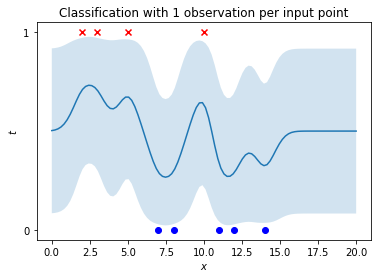

In [43]:
# plot data
plt.plot(testpoints, probabilities, lw=1.5, ls='-')
plt.fill_between(testpoints.ravel(), lowerbound, upperbound, alpha=0.2)
plt.scatter(paramValueSet[paramValueOutputs == 0], paramValueOutputs[paramValueOutputs == 0], marker='o', c='blue')
plt.scatter(paramValueSet[paramValueOutputs == 1], paramValueOutputs[paramValueOutputs == 1], marker='x', c='red')
plt.title('Classification with 1 observation per input point')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.yticks([0, 1])
plt.show()